In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import sqrt, cos, sin, pi

class CellularGeometryCluster:
    def __init__(self, i, j):
        self.i = i
        self.j = j
        self.N = i**2 + j**2 + i*j
        self.cell_radius = 1.0
        self.co_channel_cells = []
        self.center_cell = (0, 0)

    def calculate_hex_vertices(self, center_x, center_y, radius):
        vertices = []
        for k in range(6):
            angle = k * pi / 3  # 60 degrees in radians
            x = center_x + radius * cos(angle)
            y = center_y + radius * sin(angle)
            vertices.append((x, y))
        return vertices

    def get_hex_center(self, q, r):
        x = self.cell_radius * (3/2 * q)
        y = self.cell_radius * (sqrt(3)/2 * q + sqrt(3) * r)
        return (x, y)

    def find_co_channel_cells(self):
        co_cells = []
        for direction in range(6):
            q1, r1 = self.move_in_direction(0, 0, direction, self.i)
            new_direction = (direction + 1) % 6
            q2, r2 = self.move_in_direction(q1, r1, new_direction, self.j)
            co_cells.append((q2, r2))
        self.co_channel_cells = list(set(co_cells))
        return self.co_channel_cells

    def move_in_direction(self, start_q, start_r, direction, steps):
        directions = [
            (1, 0),   # East
            (1, -1),  # Northeast
            (0, -1),  # Northwest
            (-1, 0),  # West
            (-1, 1),  # Southwest
            (0, 1)    # Southeast
        ]
        dq, dr = directions[direction]
        return (start_q + steps * dq, start_r + steps * dr)

    def create_extended_grid(self, grid_size=10):
        cells = []
        for q in range(-grid_size, grid_size + 1):
            for r in range(-grid_size, grid_size + 1):
                if abs(q + r) <= grid_size:
                    cells.append((q, r))
        return cells

    def calculate_reuse_distance(self):
        if not self.co_channel_cells:
            self.find_co_channel_cells()
        if self.co_channel_cells:
            q, r = self.co_channel_cells[0]
            center_pos = self.get_hex_center(0, 0)
            co_pos = self.get_hex_center(q, r)
            distance = sqrt((co_pos[0] - center_pos[0])**2 + (co_pos[1] - center_pos[1])**2)
            reuse_ratio = distance / self.cell_radius
            theoretical_ratio = sqrt(3 * self.N)
            return distance, reuse_ratio, theoretical_ratio
        return None, None, None

    def get_cluster_info(self):
        co_cells = self.find_co_channel_cells()
        distance, reuse_ratio, theoretical_ratio = self.calculate_reuse_distance()
        info = {
            'parameters': (self.i, self.j),
            'cluster_size': self.N,
            'co_channel_cells': co_cells,
            'num_co_cells': len(co_cells),
            'reuse_distance': distance,
            'reuse_ratio': reuse_ratio,
            'theoretical_ratio': theoretical_ratio
        }
        return info

    def plot_cluster_diagram(self, show_extended_grid=True, grid_size=5, show_coordinates=True):
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        co_cells = self.find_co_channel_cells()
        if show_extended_grid:
            all_cells = self.create_extended_grid(grid_size)
            for q, r in all_cells:
                center = self.get_hex_center(q, r)
                vertices = self.calculate_hex_vertices(center[0], center[1], self.cell_radius)
                hex_patch = patches.Polygon(vertices, closed=True,
                                          facecolor='lightgray',
                                          edgecolor='gray',
                                          alpha=0.3, linewidth=0.5)
                ax.add_patch(hex_patch)
                if show_coordinates and abs(q) <= 3 and abs(r) <= 3:
                    ax.text(center[0], center[1] - 0.3, f'({q},{r})',
                           ha='center', va='center', fontsize=6, alpha=0.7)
        # Draw the center cell
        center = self.get_hex_center(0, 0)
        vertices = self.calculate_hex_vertices(center[0], center[1], self.cell_radius)
        center_patch = patches.Polygon(vertices, closed=True,
                                     facecolor='red',
                                     edgecolor='darkred',
                                     alpha=0.8, linewidth=3)
        ax.add_patch(center_patch)
        ax.text(center[0], center[1], 'CENTER\n(0,0)', ha='center', va='center',
                fontweight='bold', fontsize=10, color='white')
        # Draw co-channel cells
        colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']
        for idx, (q, r) in enumerate(co_cells):
            center_pos = self.get_hex_center(q, r)
            vertices = self.calculate_hex_vertices(center_pos[0], center_pos[1], self.cell_radius)
            color = colors[idx % len(colors)]
            co_patch = patches.Polygon(vertices, closed=True,
                                     facecolor=color,
                                     edgecolor='black',
                                     alpha=0.8, linewidth=2)
            ax.add_patch(co_patch)
            ax.text(center_pos[0], center_pos[1], f'CO-CELL\n({q},{r})',
                    ha='center', va='center', fontweight='bold',
                    fontsize=8, color='white')
        # Draw lines from center to co-channel cells
        center_pos = self.get_hex_center(0, 0)
        for q, r in co_cells:
            co_pos = self.get_hex_center(q, r)
            ax.plot([center_pos[0], co_pos[0]], [center_pos[1], co_pos[1]],
                   'k--', alpha=0.6, linewidth=1.5)
            mid_x = (center_pos[0] + co_pos[0]) / 2
            mid_y = (center_pos[1] + co_pos[1]) / 2
            distance = sqrt((co_pos[0] - center_pos[0])**2 + (co_pos[1] - center_pos[1])**2)
            ax.text(mid_x, mid_y, f'D={distance:.1f}',
                   ha='center', va='center', fontsize=7,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))
        distance, reuse_ratio, theoretical_ratio = self.calculate_reuse_distance()
        info_text = f'Cluster Parameters: i={self.i}, j={self.j}\n'
        info_text += f'Cluster Size N = i² + j² + ij = {self.N}\n'
        info_text += f'Number of Co-channel Cells: {len(co_cells)}\n'
        if distance:
            info_text += f'Co-channel Distance D = {distance:.2f}\n'
            info_text += f'Cell Radius R = {self.cell_radius}\n'
            info_text += f'Reuse Ratio Q = D/R = {reuse_ratio:.2f}\n'
            info_text += f'Theoretical Q = √(3N) = {theoretical_ratio:.2f}'
        ax.text(0.02, 0.98, info_text,
               transform=ax.transAxes, fontsize=11,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
        max_coord = max(grid_size, 4) + 2
        ax.set_xlim(-max_coord * 1.5, max_coord * 1.5)
        ax.set_ylim(-max_coord * 1.5, max_coord * 1.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Cellular Geometry N={self.N} Cluster (i={self.i}, j={self.j})\n'
                    f'Co-Channel Cell Pattern and Reuse Distance',
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('X Coordinate (Cell Radius Units)', fontsize=12)
        ax.set_ylabel('Y Coordinate (Cell Radius Units)', fontsize=12)
        legend_elements = [
            patches.Patch(color='red', label='Center Cell (Reference)'),
            patches.Patch(color='blue', label='Co-Channel Cells'),
            patches.Patch(color='lightgray', label='Other Cells', alpha=0.3)
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
        plt.tight_layout()
        return fig, ax

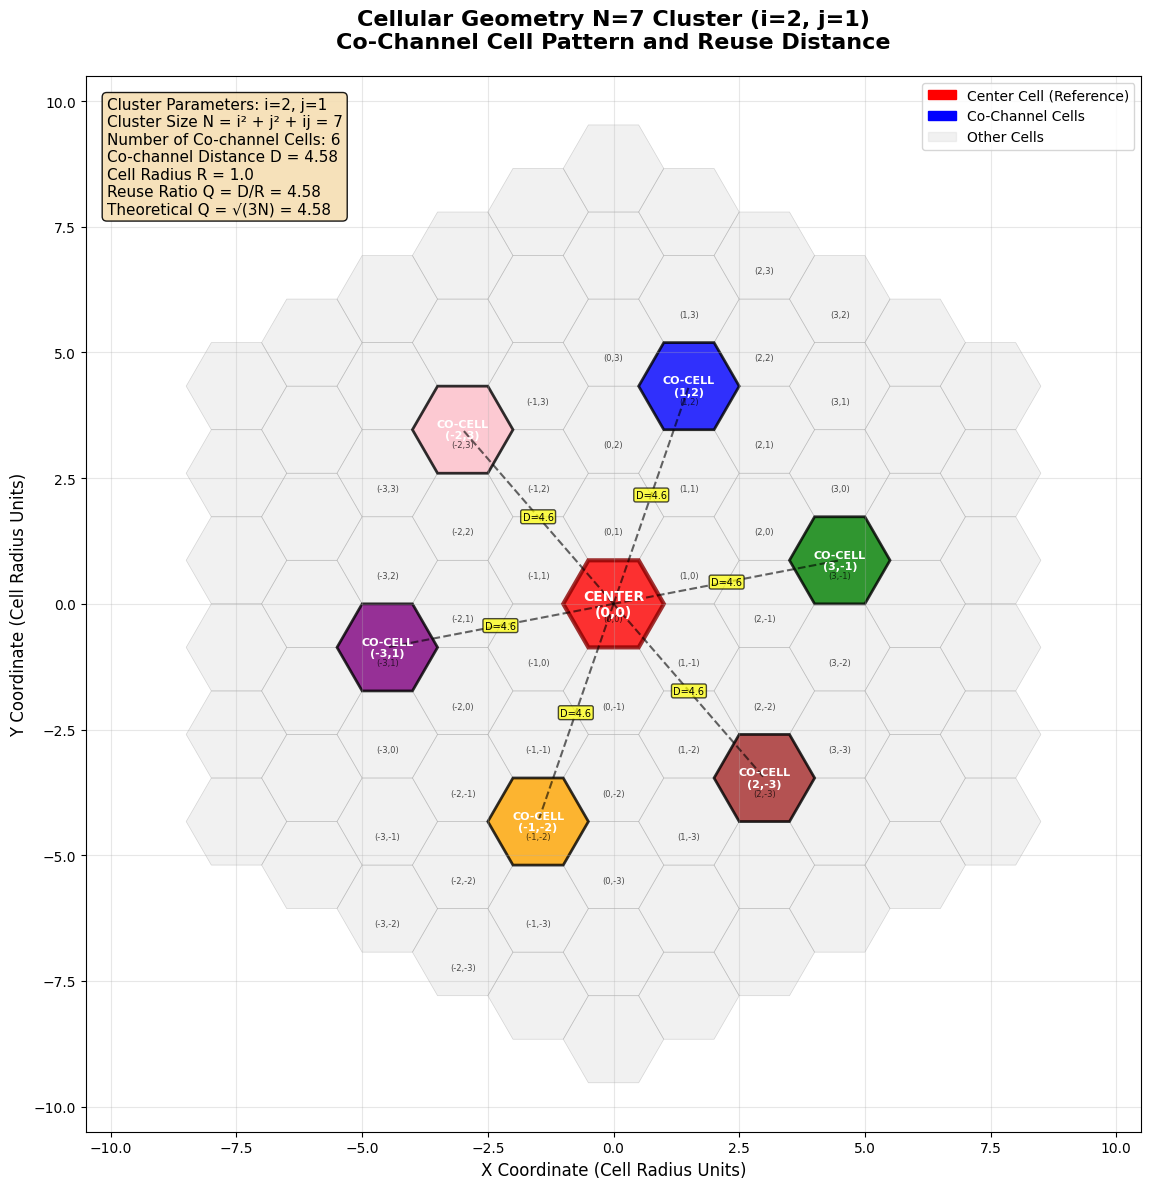

In [ ]:
cluster = CellularGeometryCluster(i=2, j=1)
cluster.plot_cluster_diagram()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import sqrt, cos, sin, pi

class CellularGeometryCluster:
    def __init__(self, i, j):
        self.i = i
        self.j = j
        self.N = i**2 + j**2 + i*j
        self.cell_radius = 1.0
        self.co_channel_cells = []
        self.center_cell = (0, 0)

    def calculate_hex_vertices(self, center_x, center_y, radius):
        vertices = []
        for k in range(6):
            angle = k * pi / 3  # 60 degrees in radians
            x = center_x + radius * cos(angle)
            y = center_y + radius * sin(angle)
            vertices.append((x, y))
        return vertices

    def get_hex_center(self, q, r):
        x = self.cell_radius * (3/2 * q)
        y = self.cell_radius * (sqrt(3)/2 * q + sqrt(3) * r)
        return (x, y)

    def find_co_channel_cells(self):
        co_cells = []
        for direction in range(6):
            q1, r1 = self.move_in_direction(0, 0, direction, self.i)
            new_direction = (direction + 1) % 6
            q2, r2 = self.move_in_direction(q1, r1, new_direction, self.j)
            co_cells.append((q2, r2))
        self.co_channel_cells = list(set(co_cells))
        return self.co_channel_cells

    def move_in_direction(self, start_q, start_r, direction, steps):
        directions = [
            (1, 0),   # East
            (1, -1),  # Northeast
            (0, -1),  # Northwest
            (-1, 0),  # West
            (-1, 1),  # Southwest
            (0, 1)    # Southeast
        ]
        dq, dr = directions[direction]
        return (start_q + steps * dq, start_r + steps * dr)

    def create_extended_grid(self, grid_size=10):
        cells = []
        for q in range(-grid_size, grid_size + 1):
            for r in range(-grid_size, grid_size + 1):
                if abs(q + r) <= grid_size:
                    cells.append((q, r))
        return cells

    def calculate_reuse_distance(self):
        if not self.co_channel_cells:
            self.find_co_channel_cells()
        if self.co_channel_cells:
            q, r = self.co_channel_cells[0]
            center_pos = self.get_hex_center(0, 0)
            co_pos = self.get_hex_center(q, r)
            distance = sqrt((co_pos[0] - center_pos[0])**2 + (co_pos[1] - center_pos[1])**2)
            reuse_ratio = distance / self.cell_radius
            theoretical_ratio = sqrt(3 * self.N)
            return distance, reuse_ratio, theoretical_ratio
        return None, None, None

    def get_cluster_info(self):
        co_cells = self.find_co_channel_cells()
        distance, reuse_ratio, theoretical_ratio = self.calculate_reuse_distance()
        info = {
            'parameters': (self.i, self.j),
            'cluster_size': self.N,
            'co_channel_cells': co_cells,
            'num_co_cells': len(co_cells),
            'reuse_distance': distance,
            'reuse_ratio': reuse_ratio,
            'theoretical_ratio': theoretical_ratio
        }
        return info

    def plot_cluster_diagram(self, show_extended_grid=True, grid_size=5, show_coordinates=True):
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        co_cells = self.find_co_channel_cells()
        if show_extended_grid:
            all_cells = self.create_extended_grid(grid_size)
            for q, r in all_cells:
                center = self.get_hex_center(q, r)
                vertices = self.calculate_hex_vertices(center[0], center[1], self.cell_radius)
                hex_patch = patches.Polygon(vertices, closed=True,
                                          facecolor='lightgray',
                                          edgecolor='gray',
                                          alpha=0.3, linewidth=0.5)
                ax.add_patch(hex_patch)
                if show_coordinates and abs(q) <= 3 and abs(r) <= 3:
                    ax.text(center[0], center[1] - 0.3, f'({q},{r})',
                           ha='center', va='center', fontsize=6, alpha=0.7)
        # Draw the center cell
        center = self.get_hex_center(0, 0)
        vertices = self.calculate_hex_vertices(center[0], center[1], self.cell_radius)
        center_patch = patches.Polygon(vertices, closed=True,
                                     facecolor='red',
                                     edgecolor='darkred',
                                     alpha=0.8, linewidth=3)
        ax.add_patch(center_patch)
        ax.text(center[0], center[1], 'CENTER\n(0,0)', ha='center', va='center',
                fontweight='bold', fontsize=10, color='white')
        # Draw co-channel cells
        colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']
        for idx, (q, r) in enumerate(co_cells):
            center_pos = self.get_hex_center(q, r)
            vertices = self.calculate_hex_vertices(center_pos[0], center_pos[1], self.cell_radius)
            color = colors[idx % len(colors)]
            co_patch = patches.Polygon(vertices, closed=True,
                                     facecolor=color,
                                     edgecolor='black',
                                     alpha=0.8, linewidth=2)
            ax.add_patch(co_patch)
            ax.text(center_pos[0], center_pos[1], f'CO-CELL\n({q},{r})',
                    ha='center', va='center', fontweight='bold',
                    fontsize=8, color='white')
        # Draw lines from center to co-channel cells
        center_pos = self.get_hex_center(0, 0)
        for q, r in co_cells:
            co_pos = self.get_hex_center(q, r)
            ax.plot([center_pos[0], co_pos[0]], [center_pos[1], co_pos[1]],
                   'k--', alpha=0.6, linewidth=1.5)
            mid_x = (center_pos[0] + co_pos[0]) / 2
            mid_y = (center_pos[1] + co_pos[1]) / 2
            distance = sqrt((co_pos[0] - center_pos[0])**2 + (co_pos[1] - center_pos[1])**2)
            ax.text(mid_x, mid_y, f'D={distance:.1f}',
                   ha='center', va='center', fontsize=7,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))
        distance, reuse_ratio, theoretical_ratio = self.calculate_reuse_distance()
        info_text = f'Cluster Parameters: i={self.i}, j={self.j}\n'
        info_text += f'Cluster Size N = i² + j² + ij = {self.N}\n'
        info_text += f'Number of Co-channel Cells: {len(co_cells)}\n'
        if distance:
            info_text += f'Co-channel Distance D = {distance:.2f}\n'
            info_text += f'Cell Radius R = {self.cell_radius}\n'
            info_text += f'Reuse Ratio Q = D/R = {reuse_ratio:.2f}\n'
            info_text += f'Theoretical Q = √(3N) = {theoretical_ratio:.2f}'
        ax.text(0.02, 0.98, info_text,
               transform=ax.transAxes, fontsize=11,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
        max_coord = max(grid_size, 4) + 2
        ax.set_xlim(-max_coord * 1.5, max_coord * 1.5)
        ax.set_ylim(-max_coord * 1.5, max_coord * 1.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Cellular Geometry N={self.N} Cluster (i={self.i}, j={self.j})\n'
                    f'Co-Channel Cell Pattern and Reuse Distance',
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('X Coordinate (Cell Radius Units)', fontsize=12)
        ax.set_ylabel('Y Coordinate (Cell Radius Units)', fontsize=12)
        legend_elements = [
            patches.Patch(color='red', label='Center Cell (Reference)'),
            patches.Patch(color='blue', label='Co-Channel Cells'),
            patches.Patch(color='lightgray', label='Other Cells', alpha=0.3)
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
        plt.tight_layout()
        return fig, ax

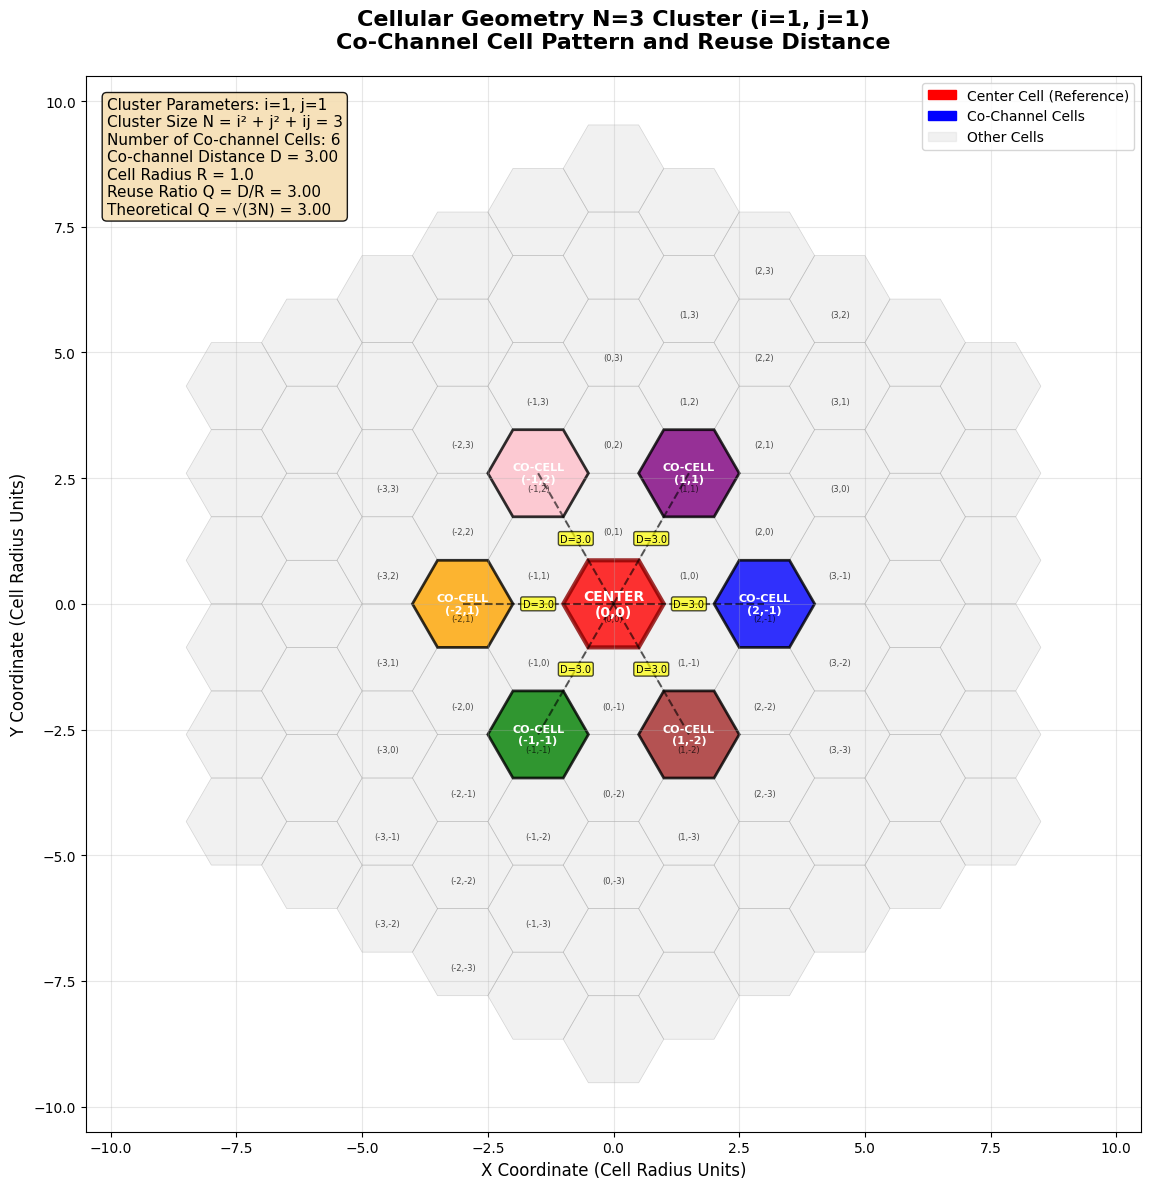

In [2]:
cluster = CellularGeometryCluster(i=1, j=1)
cluster.plot_cluster_diagram()
plt.show()

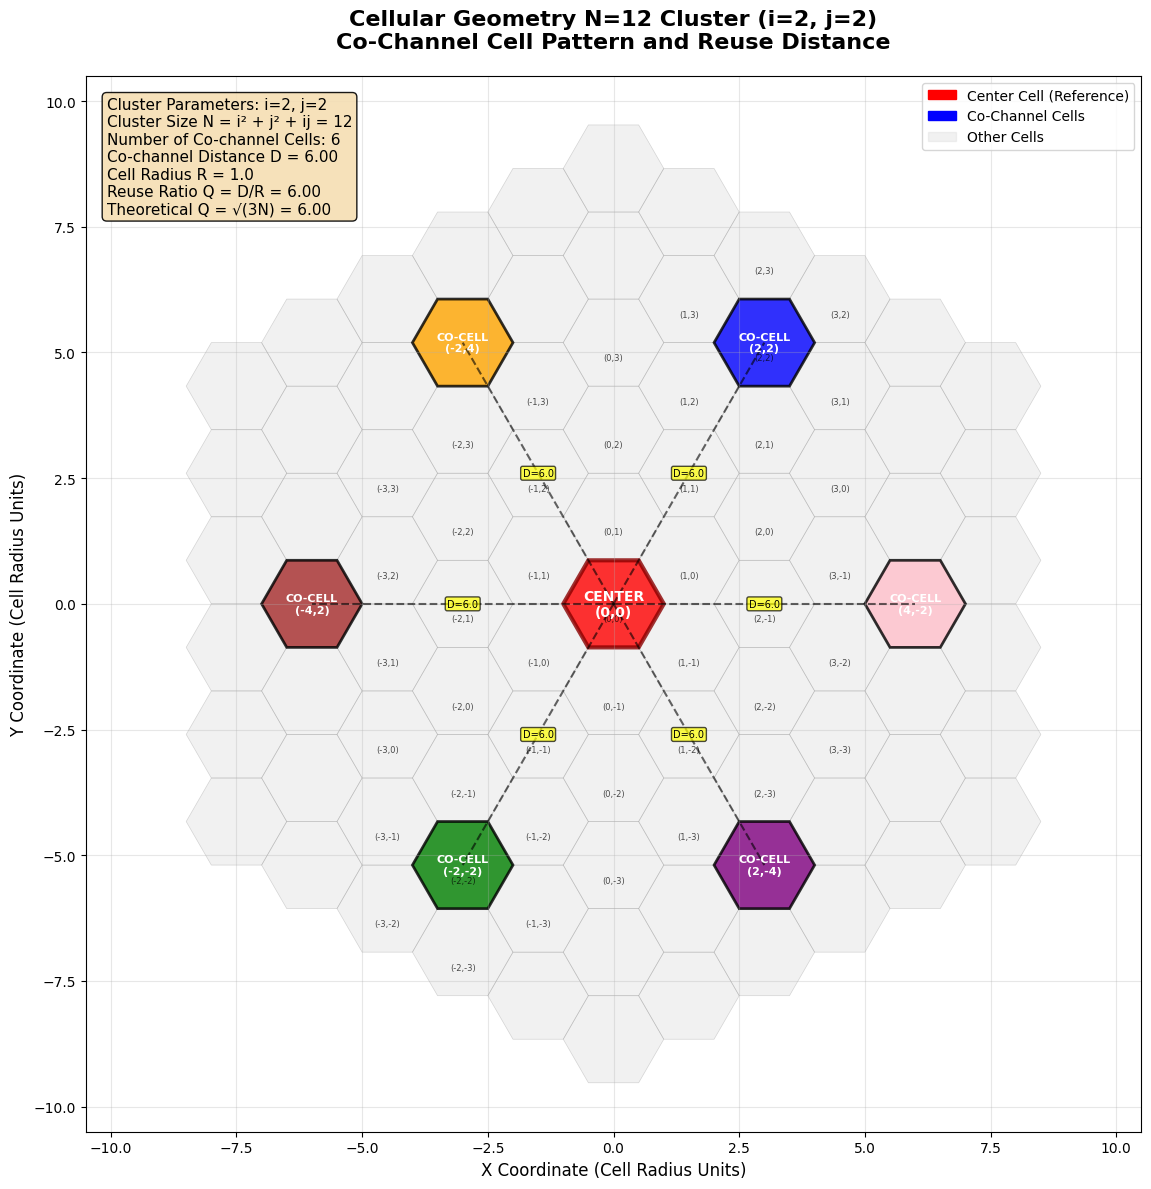

In [3]:
cluster = CellularGeometryCluster(i=2, j=2)
cluster.plot_cluster_diagram()
plt.show()